C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:85: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\typing.py:123: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] 指定されたプロシージャが見つかりません。
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the s

Using device: cuda


Loading MATLAB data:   0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\kazuya\AppData\Local\Temp\ipykernel_42780\3578715119.py:64: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)
Loading MATLAB data: 100%|██████████| 1000/1000 [00:00<00:00, 1103.62it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 230909854520.0746
Epoch 2, Loss: 24970495949.2187
Epoch 3, Loss: 695270.4819
Epoch 4, Loss: 55869.7985
Epoch 5, Loss: 66924.3290
Epoch 6, Loss: 96973.4105
Epoch 7, Loss: 578076.8864
Epoch 8, Loss: 4146912.3147
Epoch 9, Loss: 11510305.7267
Epoch 10, Loss: 4069730.6631
Epoch 11, Loss: 1113938.3766
Epoch 12, Loss: 72783.8369
Epoch 13, Loss: 956468.0975
Epoch 14, Loss: 130935.4779
Epoch 15, Loss: 109269.7191
Epoch 16, Loss: 5621283437.9410
Epoch 17, Loss: 1.0625
Epoch 18, Loss: 1.0625
Epoch 19, Loss: 1.0625
Epoch 20, Loss: 1.0625
Epoch 21, Loss: 1.0625
Epoch 22, Loss: 1.0625
Epoch 23, Loss: 1.0624
Epoch 24, Loss: 1.0624
Epoch 25, Loss: 1.0623
Epoch 26, Loss: 1.0621
Epoch 27, Loss: 9.7154
Epoch 28, Loss: 1.0615
Epoch 29, Loss: 1.0608
Epoch 30, Loss: 1.0598
Epoch 31, Loss: 1.0582
Epoch 32, Loss: 1.0558
Epoch 33, Loss: 1.0524
Epoch 34, Loss: 1.0477
Epoch 35, Loss: 1.0423
Epoch 36, Loss: 1.0368
Epoch 37, Loss: 1.0324
Epoch 38, Loss: 1.0297
Epoch 39, Loss: 1.0289
Epoch 40, Loss: 

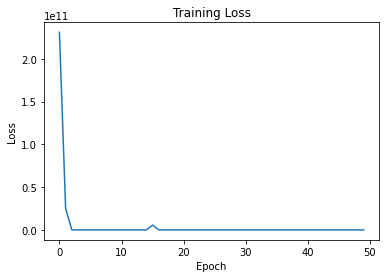

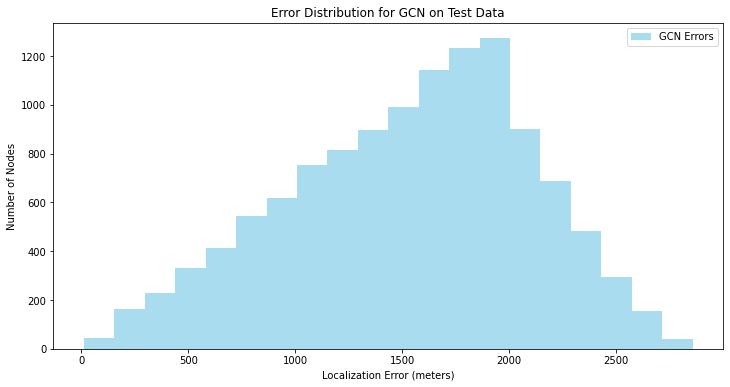

GCN Mean Error: 1535.0104 m, Median Error: 1602.8745 m


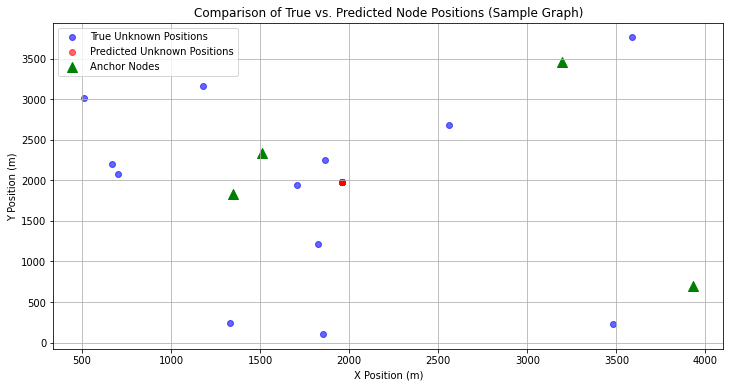

In [1]:
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.nn import NNConv, global_mean_pool
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 1000
num_anchors = 4    # Number of anchor nodes
num_unknowns = 12  # Number of unknown nodes
num_measurements = 10

# Origin from MATLAB code (for coordinate conversion)
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (np.pi / 180) * earthRadius
metersPerDegreeLon = (np.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Data Loading and Preparation
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Compute average anchor position for better unknown initialization
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    # Node features: [x, y, is_anchor]
    # Anchors: true position
    # Unknowns: initialized near average anchor position with small random noise
    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask
    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Environment GNN
#######################################
# This GNN processes only the anchor subgraph to produce a single environment embedding vector.
# We'll use a simple NNConv GNN and global_mean_pool to get one embedding vector per graph.

class EnvEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EnvEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 32),
            ReLU(),
            Linear(32, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class EnvironmentGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, env_dim):
        super(EnvironmentGNN, self).__init__()
        # Two-layer NNConv GNN over anchors only
        self.edge_nn1 = EnvEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = EnvEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        # Final linear layer to produce environment embedding
        self.fc = Linear(hidden_dim, env_dim)

    def forward(self, x, edge_index, edge_attr):
        # x: anchor node features
        # edge_index, edge_attr: anchor-to-anchor links
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)

        # Pool over anchor nodes
        # Since batch_size=1, all anchor nodes belong to the same graph
        batch = torch.zeros(x.size(0), dtype=torch.long, device=x.device)
        x = global_mean_pool(x, batch)

        env_embed = self.fc(x)
        return env_embed  # shape [1, env_dim]

#######################################
# Main GNN with Environment Embedding
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

#######################################
# Combined Model
#######################################
# We'll have:
# 1) env_gnn: produces env_embed from anchor subgraph
# 2) main_gnn: takes node features (with env_embed concatenated) and edge attributes to predict positions.

node_in_dim = data_list[0].x.shape[1]   # [scaled_x, scaled_y, is_anchor]
env_dim = 16                            # dimension of environment embedding
main_node_in_dim = node_in_dim + env_dim
edge_in_dim = num_measurements
hidden_dim = 64
output_dim = 2

env_gnn = EnvironmentGNN(node_in_dim=node_in_dim,
                         edge_in_dim=edge_in_dim,
                         hidden_dim=32,  # smaller hidden_dim for env_gnn
                         env_dim=env_dim).to(device)

main_gnn = MainGNN(node_in_dim=main_node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(env_gnn.parameters()) + list(main_gnn.parameters())
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)

#######################################
# Training
#######################################
model_train_losses = []
num_epochs = 50

for epoch in range(num_epochs):
    total_loss = 0
    env_gnn.train()
    main_gnn.train()
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Extract anchor subgraph
        mask_src = data.anchor_mask[data.edge_index[0]]
        mask_dst = data.anchor_mask[data.edge_index[1]]
        env_edge_mask = mask_src & mask_dst
        env_edge_index = data.edge_index[:, env_edge_mask]
        env_edge_attr = data.edge_attr[env_edge_mask]
        env_x = data.x[data.anchor_mask]

        # Get environment embedding
        env_embed = env_gnn(env_x, env_edge_index, env_edge_attr)  # [1, env_dim]

        # Broadcast env_embed to all nodes
        # env_embed is a single vector for the graph, repeat for each node
        env_embed_repeated = env_embed.repeat(data.x.size(0), 1)
        main_x = torch.cat([data.x, env_embed_repeated], dim=-1)

        # Predict positions with main_gnn
        out = main_gnn(main_x, data.edge_index, data.edge_attr)

        # Compute loss only for unknown nodes
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    model_train_losses.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

#######################################
# Plot Training Loss
#######################################
plt.figure()
plt.plot(model_train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
env_gnn.eval()
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        # Environment embedding for test graph
        mask_src = data.anchor_mask[data.edge_index[0]]
        mask_dst = data.anchor_mask[data.edge_index[1]]
        env_edge_mask = mask_src & mask_dst
        env_edge_index = data.edge_index[:, env_edge_mask]
        env_edge_attr = data.edge_attr[env_edge_mask]
        env_x = data.x[data.anchor_mask]

        env_embed = env_gnn(env_x, env_edge_index, env_edge_attr)
        env_embed_repeated = env_embed.repeat(data.x.size(0), 1)
        main_x = torch.cat([data.x, env_embed_repeated], dim=-1)

        out = main_gnn(main_x, data.edge_index, data.edge_attr)

        # Inverse transform predictions and ground truth
        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        # Overwrite anchor positions with ground truth
        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Compute Euclidean distance errors for unknown nodes
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)

plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

#######################################
# Visualization of One Sample
#######################################
sample_data = data_list[0].to(device)
with torch.no_grad():
    mask_src = sample_data.anchor_mask[sample_data.edge_index[0]]
    mask_dst = sample_data.anchor_mask[sample_data.edge_index[1]]
    env_edge_mask = mask_src & mask_dst
    env_edge_index = sample_data.edge_index[:, env_edge_mask]
    env_edge_attr = sample_data.edge_attr[env_edge_mask]
    env_x = sample_data.x[sample_data.anchor_mask]

    env_embed = env_gnn(env_x, env_edge_index, env_edge_attr)
    env_embed_repeated = env_embed.repeat(sample_data.x.size(0), 1)
    main_x = torch.cat([sample_data.x, env_embed_repeated], dim=-1)

    out = main_gnn(main_x, sample_data.edge_index, sample_data.edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 1000/1000 [00:00<00:00, 1073.13it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 315987.0001
Epoch 2, Loss: 116901.8911
Epoch 3, Loss: 1.0290
Epoch 4, Loss: 1.0288
Epoch 5, Loss: 1.0288
Epoch 6, Loss: 1.0288
Epoch 7, Loss: 1.0288
Epoch 8, Loss: 1.0288
Epoch 9, Loss: 1.0288
Epoch 10, Loss: 1.0288
Epoch 11, Loss: 1.0288
Epoch 12, Loss: 1.0287
Epoch 13, Loss: 1.0289
Epoch 14, Loss: 1.0289
Epoch 15, Loss: 1.0289
Epoch 16, Loss: 1.0290
Epoch 17, Loss: 1.0290
Epoch 18, Loss: 1.0288
Epoch 19, Loss: 1.0290
Epoch 20, Loss: 1.0291
Epoch 21, Loss: 1.0289
Epoch 22, Loss: 1.0290
Epoch 23, Loss: 842.8056
Epoch 24, Loss: 12.9099
Epoch 25, Loss: 1.0721
Epoch 26, Loss: 1.1383
Epoch 27, Loss: 1.0288
Epoch 28, Loss: 1.0288
Epoch 29, Loss: 1.0288
Epoch 30, Loss: 1.0288
Epoch 31, Loss: 1.0325
Epoch 32, Loss: 1.0299
Epoch 33, Loss: 1.0288
Epoch 34, Loss: 1.0339
Epoch 35, Loss: 1.0289
Epoch 36, Loss: 1.0778
Epoch 37, Loss: 1.0289
Epoch 38, Loss: 1.0289
Epoch 39, Loss: 1.0290
Epoch 40, Loss: 1.0367
Epoch 41, Loss: 1.0289
Epoch 42, Loss: 1.0288
Epoch 43, Loss: 1.0289
Epoch 4

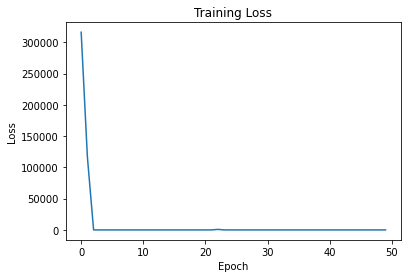

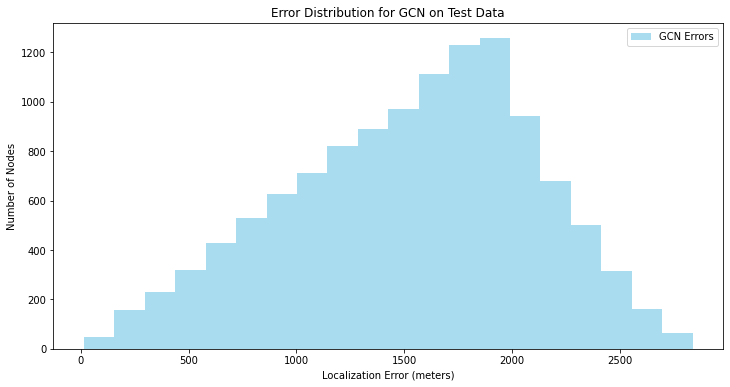

GCN Mean Error: 1534.7348 m, Median Error: 1602.0066 m


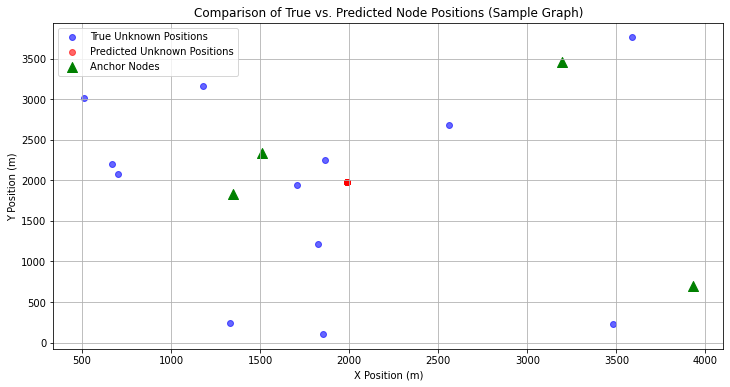

In [3]:
import torch
import numpy as np
from scipy.io import loadmat
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.nn import NNConv
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 1000
num_anchors = 4    # Number of anchor nodes
num_unknowns = 12  # Number of unknown nodes
num_measurements = 10

mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (np.pi / 180) * earthRadius
metersPerDegreeLon = (np.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Data Loading
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask
    data_list.append(data)

#######################################
# Scaling
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

#######################################
# Global Environment Embedding
#######################################
env_dim = 16
# Create a leaf parameter directly on the device:
env_embed = Parameter(torch.randn(env_dim, device=device, requires_grad=True))

node_in_dim = data_list[0].x.shape[1]
main_node_in_dim = node_in_dim + env_dim
edge_in_dim = num_measurements
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=main_node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [env_embed]
optimizer = torch.optim.Adam(params, lr=1e-3, weight_decay=1e-5)

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        env_embed_repeated = env_embed.unsqueeze(0).repeat(data.x.size(0), 1)
        main_x = torch.cat([data.x, env_embed_repeated], dim=-1)

        out = main_gnn(main_x, data.edge_index, data.edge_attr)
        loss = F.mse_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        env_embed_repeated = env_embed.unsqueeze(0).repeat(data.x.size(0), 1)
        main_x = torch.cat([data.x, env_embed_repeated], dim=-1)
        out = main_gnn(main_x, data.edge_index, data.edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        # Compute Euclidean errors
        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    env_embed_repeated = env_embed.unsqueeze(0).repeat(sample_data.x.size(0), 1)
    main_x = torch.cat([sample_data.x, env_embed_repeated], dim=-1)
    out = main_gnn(main_x, sample_data.edge_index, sample_data.edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()


Using device: cuda


Loading MATLAB data: 100%|██████████| 1000/1000 [00:00<00:00, 1028.09it/s]
C:\Users\kazuya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 8.1195
Epoch 2, Loss: 3.9955
Epoch 3, Loss: 2.8532
Epoch 4, Loss: 2.2491
Epoch 5, Loss: 1.7458
Epoch 6, Loss: 1.4621
Epoch 7, Loss: 1.0969
Epoch 8, Loss: 0.7957
Epoch 9, Loss: 0.6893
Epoch 10, Loss: 0.5424
Epoch 11, Loss: 0.4341
Epoch 12, Loss: 0.3148
Epoch 13, Loss: 0.2507
Epoch 14, Loss: 0.2348
Epoch 15, Loss: 0.2076
Epoch 16, Loss: 0.1857
Epoch 17, Loss: 0.1640
Epoch 18, Loss: 0.1459
Epoch 19, Loss: 0.1389
Epoch 20, Loss: 0.1231
Epoch 21, Loss: 0.1157
Epoch 22, Loss: 0.1132
Epoch 23, Loss: 0.0942
Epoch 24, Loss: 0.0915
Epoch 25, Loss: 0.0857
Epoch 26, Loss: 0.0789
Epoch 27, Loss: 0.0712
Epoch 28, Loss: 0.0687
Epoch 29, Loss: 0.0633
Epoch 30, Loss: 0.0610
Epoch 31, Loss: 0.0560
Epoch 32, Loss: 0.0548
Epoch 33, Loss: 0.0544
Epoch 34, Loss: 0.0502
Epoch 35, Loss: 0.0502
Epoch 36, Loss: 0.0465
Epoch 37, Loss: 0.0433
Epoch 38, Loss: 0.0422
Epoch 39, Loss: 0.0408
Epoch 40, Loss: 0.0396
Epoch 41, Loss: 0.0380
Epoch 42, Loss: 0.0357
Epoch 43, Loss: 0.0352
Epoch 44, Loss: 0.03

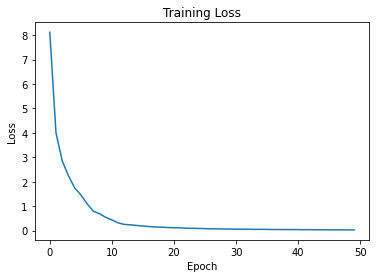

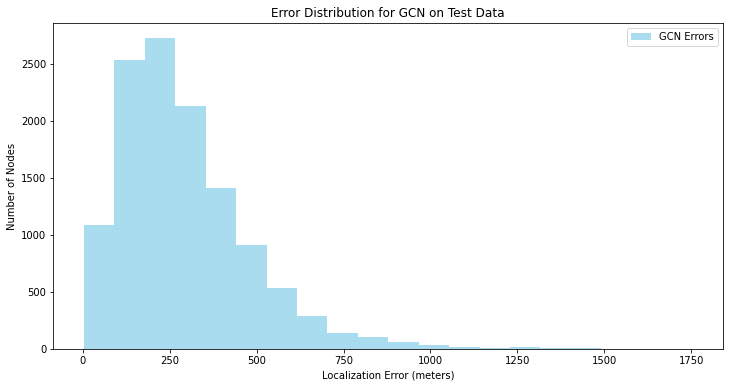

GCN Mean Error: 291.0203 m, Median Error: 253.8075 m


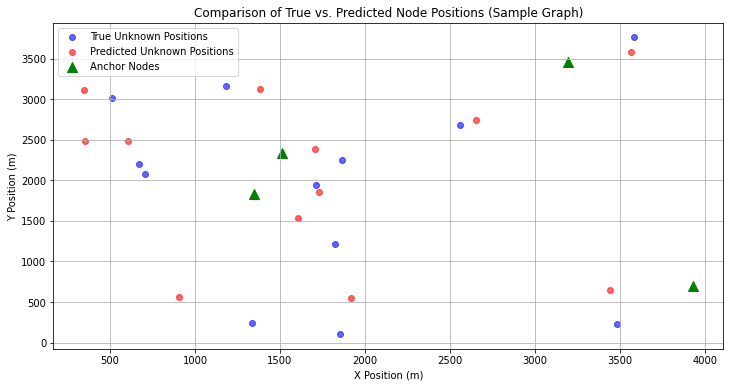

In [4]:
import torch
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU, Parameter
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import NNConv
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
from scipy.io import loadmat
from tqdm import tqdm
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

#######################################
# Parameters and Utility Functions
#######################################
num_instances = 1000
num_anchors = 4
num_unknowns = 12
num_measurements = 10

# Origin from MATLAB code
mapOriginLat = 40.466198
mapOriginLon = 33.898610
earthRadius = 6378137.0
metersPerDegreeLat = (math.pi / 180) * earthRadius
metersPerDegreeLon = (math.pi / 180) * earthRadius * np.cos(np.deg2rad(mapOriginLat))

def latlon_to_xy(lat, lon, originLat, originLon):
    x = (lon - originLon) * metersPerDegreeLon
    y = (lat - originLat) * metersPerDegreeLat
    return x, y

#######################################
# Load Data
#######################################
data_list = []
for instance_idx in tqdm(range(1, num_instances + 1), desc="Loading MATLAB data"):
    filename = f"matlab/data/mid_16beacons/data_instance_{instance_idx}.mat"
    mat_data = loadmat(filename)

    nodeLatitudes = mat_data['nodeLatitudes'].flatten()
    nodeLongitudes = mat_data['nodeLongitudes'].flatten()
    signal_strength_matrix = mat_data['signal_strength_matrix']

    num_nodes = len(nodeLatitudes)
    node_x = np.zeros(num_nodes)
    node_y = np.zeros(num_nodes)
    for i in range(num_nodes):
        node_x[i], node_y[i] = latlon_to_xy(nodeLatitudes[i], nodeLongitudes[i], mapOriginLat, mapOriginLon)

    # Construct edges
    edge_index_list = []
    edge_attr_list = []
    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j and not np.isnan(signal_strength_matrix[i, j, 0]):
                edge_index_list.append([i, j])
                # We will handle RSSI and delta_RSSI later. For now just store.
                edge_attr_list.append(signal_strength_matrix[i, j, :])

    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)

    # Identify anchors and unknowns
    anchor_mask = torch.zeros(num_nodes, dtype=torch.bool)
    anchor_mask[:num_anchors] = True
    unknown_mask = ~anchor_mask

    # Initialize unknowns near average anchor position
    avg_anchor_x = node_x[anchor_mask].mean()
    avg_anchor_y = node_y[anchor_mask].mean()

    node_features = []
    for i in range(num_nodes):
        is_anchor = 1 if i < num_anchors else 0
        if is_anchor:
            node_features.append([node_x[i], node_y[i], is_anchor])
        else:
            node_features.append([avg_anchor_x + np.random.randn()*10,
                                  avg_anchor_y + np.random.randn()*10,
                                  is_anchor])

    x = torch.tensor(node_features, dtype=torch.float)
    y = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    data.anchor_mask = anchor_mask
    data.unknown_mask = unknown_mask

    # Store original positions (not scaled) for distance calculation
    data.orig_positions = torch.tensor(np.column_stack((node_x, node_y)), dtype=torch.float)

    data_list.append(data)

#######################################
# Scale Features and Targets
#######################################
all_features = torch.cat([d.x for d in data_list], dim=0).numpy()
feature_scaler = StandardScaler()
feature_scaler.fit(all_features)
for d in data_list:
    d.x = torch.tensor(feature_scaler.transform(d.x.numpy()), dtype=torch.float)

all_y = torch.cat([d.y for d in data_list], dim=0).numpy()
y_scaler = StandardScaler()
y_scaler.fit(all_y)
for d in data_list:
    d.y = torch.tensor(y_scaler.transform(d.y.numpy()), dtype=torch.float)

train_loader = DataLoader(data_list, batch_size=1, shuffle=True)
test_loader = DataLoader(data_list, batch_size=1, shuffle=False)

#######################################
# Physically Inspired Parameters
#######################################
# Learnable parameters for the RSSI model
Pt = Parameter(torch.tensor(0.0, requires_grad=True, device=device))
path_loss_exponent = Parameter(torch.tensor(3.0, requires_grad=True, device=device))
offset = Parameter(torch.tensor(-50.0, requires_grad=True, device=device))

#######################################
# Model Definition
#######################################
class MainEdgeNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(MainEdgeNet, self).__init__()
        self.mlp = Sequential(
            Linear(in_channels, 64),
            ReLU(),
            Linear(64, out_channels)
        )
    def forward(self, x):
        return self.mlp(x)

class MainGNN(torch.nn.Module):
    def __init__(self, node_in_dim, edge_in_dim, hidden_dim, output_dim):
        super(MainGNN, self).__init__()
        self.edge_nn1 = MainEdgeNet(edge_in_dim, node_in_dim * hidden_dim)
        self.conv1 = NNConv(node_in_dim, hidden_dim, self.edge_nn1, aggr='mean')

        self.edge_nn2 = MainEdgeNet(edge_in_dim, hidden_dim * hidden_dim)
        self.conv2 = NNConv(hidden_dim, hidden_dim, self.edge_nn2, aggr='mean')

        self.fc = Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, edge_attr):
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        x = self.fc(x)
        return x

node_in_dim = data_list[0].x.shape[1]
# We will add delta_RSSI as one additional feature to the existing edge attributes.
# Currently, edge_attr: shape = (num_edges, num_measurements)
# After adding delta_RSSI: shape = (num_edges, num_measurements + 1)
edge_in_dim = num_measurements + 1
hidden_dim = 64
output_dim = 2

main_gnn = MainGNN(node_in_dim=node_in_dim,
                   edge_in_dim=edge_in_dim,
                   hidden_dim=hidden_dim,
                   output_dim=output_dim).to(device)

params = list(main_gnn.parameters()) + [Pt, path_loss_exponent, offset]
optimizer = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-5)  # Lower LR for stability

#######################################
# Training
#######################################
num_epochs = 50
loss_history = []

def compute_distances(orig_positions, edge_index):
    # orig_positions: [num_nodes, 2]
    # edge_index: [2, num_edges]
    # return distances [num_edges, 1]
    src = edge_index[0]
    dst = edge_index[1]
    pos_src = orig_positions[src]
    pos_dst = orig_positions[dst]
    dist = torch.sqrt(torch.sum((pos_src - pos_dst)**2, dim=1))
    return dist

for epoch in range(num_epochs):
    main_gnn.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()

        # Compute distances in original space (not scaled)
        dist = compute_distances(data.orig_positions, data.edge_index)

        # Compute expected RSSI
        # RSSI_expected = Pt - 10 * path_loss_exponent * log10(dist) + offset
        # Avoid log10(0), add a small epsilon
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset

        # measured_RSSI: take mean over the 10 measurements for simplicity
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)

        # New edge_attr: original + delta_RSSI
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        # Use Smooth L1 Loss for robustness
        loss = F.smooth_l1_loss(out[data.unknown_mask], data.y[data.unknown_mask])
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(main_gnn.parameters(), 1.0)
        torch.nn.utils.clip_grad_norm_([Pt, path_loss_exponent, offset], 1.0)

        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f'Epoch {epoch+1}, Loss: {avg_loss:.4f}')

plt.figure()
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

#######################################
# Evaluation
#######################################
main_gnn.eval()
errors_gcn = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)

        dist = compute_distances(data.orig_positions, data.edge_index)
        epsilon = 1e-6
        RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
        measured_RSSI = data.edge_attr.mean(dim=1)
        delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
        new_edge_attr = torch.cat([data.edge_attr, delta_RSSI], dim=1)

        out = main_gnn(data.x, data.edge_index, new_edge_attr)

        predicted_scaled = out.cpu().numpy()
        predicted_positions = y_scaler.inverse_transform(predicted_scaled)
        true_positions = y_scaler.inverse_transform(data.y.cpu().numpy())

        predicted_positions[data.anchor_mask.cpu()] = true_positions[data.anchor_mask.cpu()]

        for idx in range(true_positions.shape[0]):
            if data.unknown_mask[idx]:
                true_pos = true_positions[idx]
                pred_pos = predicted_positions[idx]
                error = np.sqrt((true_pos[0] - pred_pos[0])**2 + (true_pos[1] - pred_pos[1])**2)
                errors_gcn.append(error)

errors_gcn = np.array(errors_gcn)
plt.figure(figsize=(12, 6))
plt.hist(errors_gcn, bins=20, alpha=0.7, color='skyblue', label='GCN Errors')
plt.xlabel('Localization Error (meters)')
plt.ylabel('Number of Nodes')
plt.title('Error Distribution for GCN on Test Data')
plt.legend()
plt.show()

mean_error = errors_gcn.mean()
median_error = np.median(errors_gcn)
print(f"GCN Mean Error: {mean_error:.4f} m, Median Error: {median_error:.4f} m")

# Visualization of one sample
sample_data = data_list[0].to(device)
with torch.no_grad():
    dist = compute_distances(sample_data.orig_positions, sample_data.edge_index)
    epsilon = 1e-6
    RSSI_expected = Pt - 10.0 * path_loss_exponent * torch.log10(dist + epsilon) + offset
    measured_RSSI = sample_data.edge_attr.mean(dim=1)
    delta_RSSI = (measured_RSSI - RSSI_expected).unsqueeze(1)
    new_edge_attr = torch.cat([sample_data.edge_attr, delta_RSSI], dim=1)

    out = main_gnn(sample_data.x, sample_data.edge_index, new_edge_attr)
    predicted_scaled = out.cpu().numpy()
    predicted_positions = y_scaler.inverse_transform(predicted_scaled)
    true_positions = y_scaler.inverse_transform(sample_data.y.cpu().numpy())

predicted_positions[sample_data.anchor_mask.cpu()] = true_positions[sample_data.anchor_mask.cpu()]

plt.figure(figsize=(12,6))
plt.scatter(true_positions[sample_data.unknown_mask.cpu(),0],
            true_positions[sample_data.unknown_mask.cpu(),1],
            c='blue', label='True Unknown Positions', alpha=0.6)
plt.scatter(predicted_positions[sample_data.unknown_mask.cpu(),0],
            predicted_positions[sample_data.unknown_mask.cpu(),1],
            c='red', label='Predicted Unknown Positions', alpha=0.6)
plt.scatter(true_positions[sample_data.anchor_mask.cpu(),0],
            true_positions[sample_data.anchor_mask.cpu(),1],
            c='green', marker='^', s=100, label='Anchor Nodes')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.title('Comparison of True vs. Predicted Node Positions (Sample Graph)')
plt.legend()
plt.grid(True)
plt.show()
